# Importing libraries

In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Help functions

## Load data

In [3]:
def load_battery_voltage(pack_nr):
#     print("Loading the battery voltage and resampling to 5min intervals...")
#     df = pd.read_csv(r'C:\Users\Jeff\Desktop\Case 1 - data\battery_data_' + str(pack_nr) +'\Power.BatteryVoltHR_merged.csv',usecols=['time','value'])
    df = pd.read_csv(r'D:\Documents\Thesis\Case 1 - data\battery_data_' + str(pack_nr) +'\Power.BatteryVoltHR_merged.csv',usecols=['time','value'])
    # Select timestamp and value from results
    data = df[['time','value']]
    # Convert object to float (BatteryVoltHR is an object for example)
    data["value"] = pd.to_numeric(data.value, errors='coerce')
    # Rename the column
    data.rename(columns={'value':'Power.BatteryVoltHR'}, inplace=True)
    # Set timestamp as index
    data['time'] = pd.to_datetime(data.time, unit='ms')
    data = data.resample(rule='5Min', on='time').mean().interpolate()
    return data

In [4]:
def load_weather_data():
    weather_metricsList = ['environment.light','environment.temperature','weather.uv','environment.relativehumidity',
              'weather.pressure', 'weather.rainrate', 'weather.windspeed']
    for i in range(0,len(weather_metricsList)):     
        metricID = weather_metricsList[i]
#         print("Loading " + str(metricID) + " and resampling to 5min intervals...")
#         df = pd.read_csv('C:/Users/Jeff/Desktop/Case 1 - data/weather_data/'+metricID+'_merged.csv',usecols=['time','value'])
        df = pd.read_csv('D:/Documents/Thesis/Case 1 - data/weather_data/'+metricID+'_merged.csv',usecols=['time','value'])

        if(i==0):
            # Select timestamp and value from results
            data = df[['time','value']]
            # Convert object to float (BatteryVoltHR is an object for example)
            data["value"] = pd.to_numeric(data.value, errors='coerce')
            # Rename the column
            data.rename(columns={'value': metricID}, inplace=True)
            # Calculate average for time bin and replace NaN with interpolation
            data['time'] = pd.to_datetime(data.time, unit='ms')
            data = data.resample(rule='5Min', on='time').mean().interpolate()
        else:
            data2 = df[['time','value']]
            # Convert object to float (BatteryVoltHR is an object for example)
            data2["value"] = pd.to_numeric(data2.value, errors='coerce')
            # Rename the column
            data2.rename(columns={'value':metricID}, inplace=True)
            # Calculate average for time bin and replace NaN with interpolation
            data2['time'] = pd.to_datetime(data2.time, unit='ms')
            data2 = data2.resample(rule='5Min', on='time').mean().interpolate()
            data = pd.merge(data, data2, on='time')
        
    return data

In [5]:
def get_data(pack_nr):
    battery_data = load_battery_voltage(pack_nr)
    weather_data = load_weather_data()
    data = pd.merge(battery_data, weather_data, on='time')
    return data

## Extend data features

In [41]:
def add_features(X, y, nr_ts_bat, nr_ts_weather):
    if nr_ts_weather != 0:
        column_names = X.columns
        cols, names = list(), list()
        n_vars = 1 if type(X) is list else X.shape[1]
        for i in range(nr_ts_weather, 0, -1):
            cols.append(X.shift(i))
            names += [(column_names[j]+'(t-%d)' % (i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # Set timestamps back as indexes
        agg = agg.set_index(a.index)
        agg.dropna(inplace=True)
        X = agg.copy()
        
    if nr_ts_bat != 0:
        for i in range(1,nr_ts_bat+1):
            shifted_data = y['Power.BatteryVoltHR'].shift(periods=i)
            name = 'Power.BatteryVoltHR (t-{})'.format(i)
            X[name] = shifted_data
        X = X.dropna()
        
    y = y.iloc[max(nr_ts_bat,nr_ts_weather):]
    return X, y       

In [7]:
def series_to_supervised(data, indexes, column_names, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    	data: Sequence of observations as a list or NumPy array.
    	indexes: values of timestamp indexes
    	column_names: names of the columns
    	n_in: Number of lag observations as input (X).
    	n_out: Number of observations as output (y).
    	dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    	Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(column_names[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(column_names[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(column_names[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Set timestamps back as indexes
    agg = agg.set_index(indexes)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Scale and Split dataset

In [8]:
import sklearn.preprocessing

In [9]:
def scale_data(data):
    # Save column names
    col_names = data.columns
    # load dataset
    values = data.values
    indexes = data.index
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    # Transform back to dataframe
    scaled = pd.DataFrame(scaled, columns=col_names).set_index(indexes)
    
    return scaled, scaler

In [10]:
def split_data(data, training_ratio):
    # split into train and test sets
    values = data.values
    n_train = int(training_ratio * len(data))
    train = data.iloc[0:n_train]
    test = data.iloc[n_train:-1]
    # split into input and outputs
    X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0:1]
    X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0:1]
    
    return X_train, y_train, X_test, y_test

## Rescale features

In [11]:
def combine_XY(X, y, scaler):
    ct = pd.concat([y, X], sort=False, axis = 1)
    ct = scaler.inverse_transform(ct)
    return ct

## Plot results

In [12]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [13]:
def plot_pred_actual(X_test, y_test, y_pred, prev_timesteps, batt_nr):
    # Plot prediction vs test set
    fig = plt.figure(figsize=(15,8))
    plt.scatter(y_test.index, y_test, label='Actual',  color='black')
    plt.plot(X_test.index, y_pred, label='Prediction', color='blue', linewidth=3)
    plt.xlabel('Time')
    plt.ylabel('Battery voltage')
    plt.legend()
    plt.title('Linear Regression - No Regularization \n Prev timesteps: {} \n'.format(prev_timesteps))
#     plt.savefig(r'C:\Users\JeffG\Desktop\Case 1 - data\Results\Linear Regression' + '/ts_{}_batt_{}'.format(prev_timesteps, batt_nr))
    plt.show()

In [14]:
def plot_pred_actual_2(X_test, y_test, y_pred, prev_timesteps, batt_nr, scaler):
    y_test_real = combine_XY(X_test, y_test, scaler)[:, 0]
    y_pred_real = combine_XY(X_test, pd.DataFrame(y_pred).set_index(X_test.index), scaler)[:, 0]
    # Plot prediction vs test set
    fig = plt.figure(figsize=(15,8))
    plt.scatter(X_test.index, y_test_real, label='Actual',  color='black')
    plt.plot(X_test.index, y_pred_real, label='Prediction', color='blue', linewidth=3)
    plt.xlabel('Time')
    plt.ylabel('Battery voltage')
    plt.legend()
    plt.title('Linear Regression - No Regularization \n Prev timesteps: {} \n'.format(prev_timesteps))
#     plt.savefig(r'C:\Users\JeffG\Desktop\Case 1 - data\Results\Linear Regression' + '/ts_{}_batt_{}'.format(prev_timesteps, batt_nr))
    plt.show()
    return fig

In [15]:
def plot_coefficients(pipeline):
    print("Coefficients: ")
    coeff = pd.DataFrame(pipeline.named_steps['model'].coef_)
    print(coeff)
    
    plt.plot(pipeline.named_steps['model'].coef_[0],alpha=1,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
    plt.xlabel('Coefficient Index',fontsize=16)
    plt.ylabel('Coefficient Magnitude',fontsize=16)
    plt.legend(fontsize=13,loc=4)
    plt.show()
    

# Linear Regression (no regularization)

## Import library

In [16]:
from sklearn import linear_model
import sklearn.metrics
from sklearn.metrics import mean_squared_error, r2_score

## Load weather data

In [17]:
weather_data = load_weather_data()

## Load battery data for training

In [57]:
batt_nr = 2
battery_voltage = load_battery_voltage(batt_nr)
a = weather_data.copy()
b = battery_voltage.copy()

In [23]:
# weather_data.to_csv(r'D:\Documents\Thesis\Case 1 - data' + '/all_weather_data.csv')

In [24]:
# batt_nr = 1
# battery_voltage = load_battery_voltage(batt_nr)
# battery_voltage.to_csv(r'D:\Documents\Thesis\Case 1 - data' + '/battery_voltage_1.csv')
# batt_nr = 2
# battery_voltage = load_battery_voltage(batt_nr)
# battery_voltage.to_csv(r'D:\Documents\Thesis\Case 1 - data' + '/battery_voltage_2.csv')
# batt_nr = 3
# battery_voltage = load_battery_voltage(batt_nr)
# battery_voltage.to_csv(r'D:\Documents\Thesis\Case 1 - data' + '/battery_voltage_3.csv')

## Linear regression without regularization - no extra features
In this case we will use the weather data as input and the battery voltage as output.

In [20]:
# Choose settings
prev_timesteps_weather = 0
prev_timesteps_bat = 0

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)

In [73]:
X.head()

,environment.light,environment.temperature,weather.uv,environment.relativehumidity,weather.pressure,weather.rainrate,weather.windspeed
time,,,,,,,
2018-08-31 09:45:00,95338.168421,17.716316,2.007368,57.000000,1024.409158,0.0,2.033684
2018-08-31 09:50:00,95245.765697,17.716189,2.004979,57.019048,1024.403599,0.0,2.032264
2018-08-31 09:55:00,95153.362974,17.716063,2.002589,57.038095,1024.398041,0.0,2.030845
2018-08-31 10:00:00,95060.960250,17.715936,2.000199,57.057143,1024.392482,0.0,2.029425
2018-08-31 10:05:00,94968.557527,17.715810,1.997810,57.076190,1024.386924,0.0,2.028005


In [69]:
# Split data in train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Split data in train and test set without random state
# X_train, y_train, X_test, y_test = split_data(y.merge(X, on='time'), 0.7)

In [70]:
# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

Training score: 0.25947563907312676
Test score: 0.23880984666416827


The training and the test score show clearly that we are underfitting the data here. Possibilities to solve underfitting:
 * Add features
 * Add polynomial features
 * Decrease lambda

Coefficients: 
          0         1         2         3         4         5        6
0 -1.015198  2.345646  0.936363  0.191166  1.478794  0.621243 -0.11601


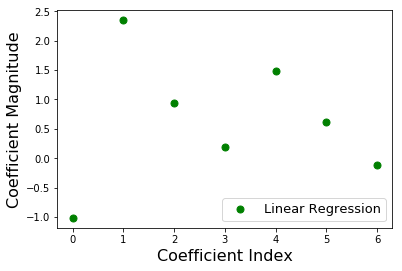

In [71]:
plot_coefficients(pipeline)

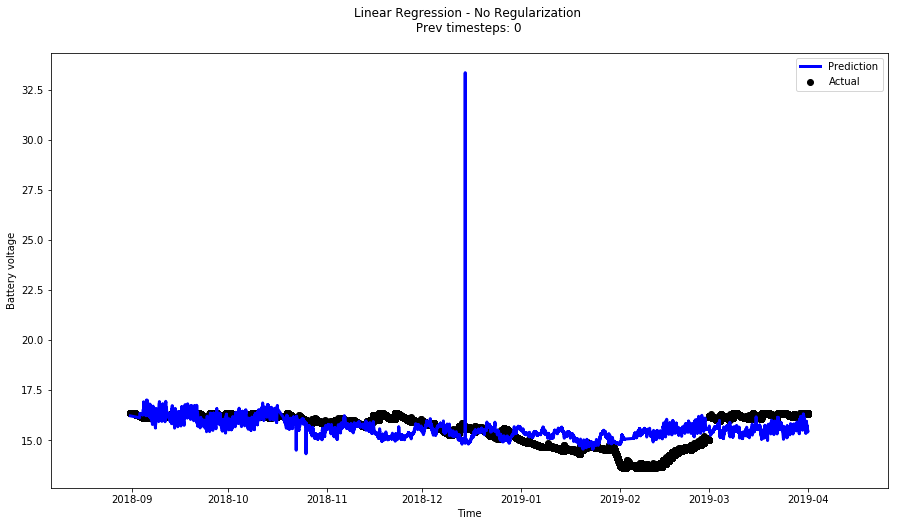

In [72]:
# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps, batt_nr)

## Linear regression without regularization - extra features
Since the previous analysis showed that we were underfitting the data and no good match was possible, we'll introduce new features. As a first attempt, we'll add data from previous timestamps as extra features. This can be data of the battery voltage but also the weather data. In the next part, we'll try to find some extra polynomials.

### Using extra battery voltages

Training score: 0.9998857697486971
Test score: 0.999937176809096
Coefficients: 
         0         1         2         3         4         5             6  \
0  0.00983 -0.000449 -0.005811  0.001548  0.001837 -0.001461 -7.541561e-07   

         7  
0  2.73991  


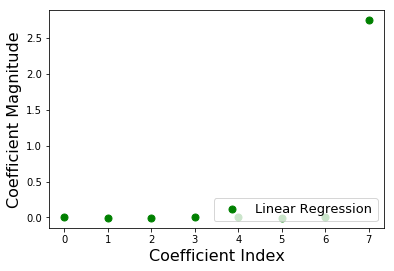

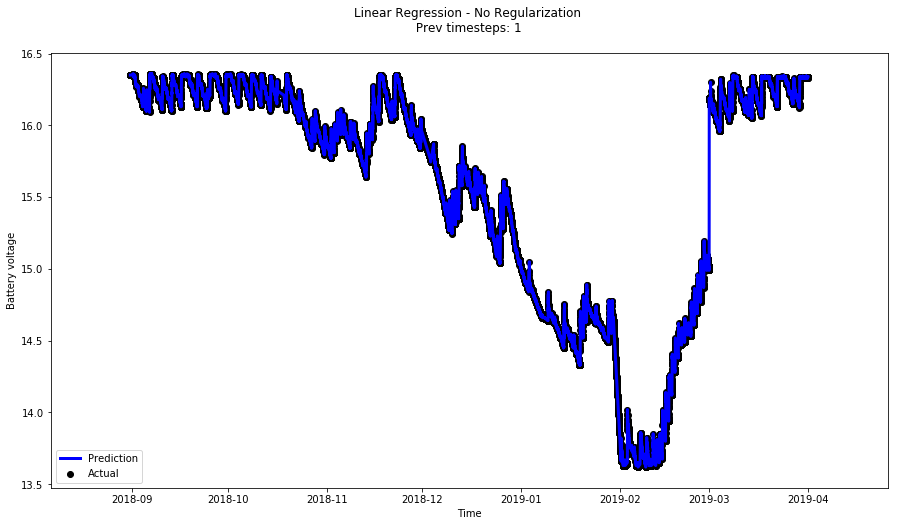

In [20]:
# Choose settings
prev_timesteps_weather = 0
prev_timesteps_bat = 1

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)

# Split data in train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

plot_coefficients(pipeline)

# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat, batt_nr)

Training score: 0.9998887020103757
Test score: 0.9999343703875125
Coefficients: 
         0         1         2         3         4         5         6   \
0  0.008363 -0.000424 -0.005212  0.001419  0.001008 -0.001585 -0.000243   

         7         8         9         10        11        12        13  \
0  2.474506  0.257843 -0.015309  0.059771  0.019861  0.008142 -0.017568   

         14        15        16  
0 -0.048793  0.047709 -0.046215  


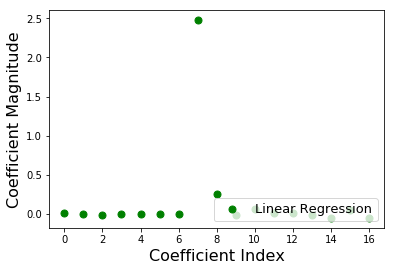

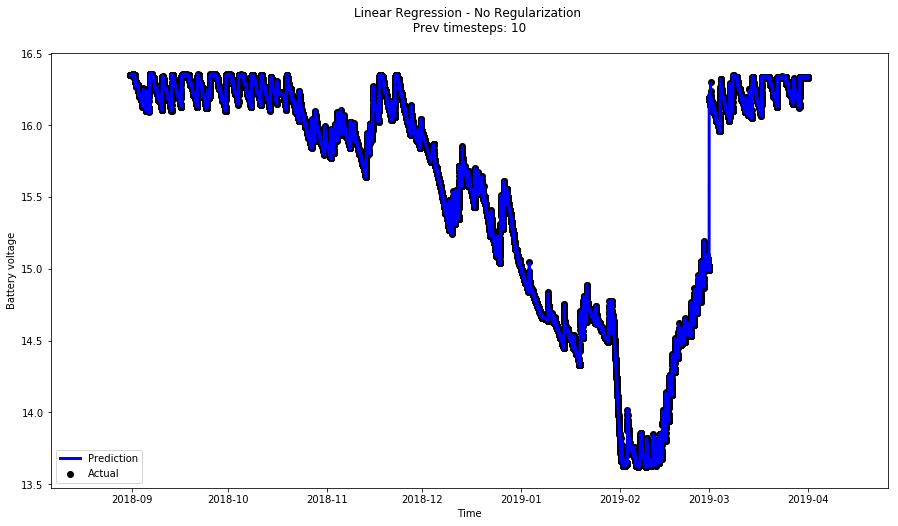

In [22]:
# Choose settings
prev_timesteps_weather = 0
prev_timesteps_bat = 10

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)

# Split data in train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

plot_coefficients(pipeline)

# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat, batt_nr)

### Using extra weather features

Training score: 0.2616103888209912
Test score: 0.2638205213178507
Coefficients: 
         0         1         2         3        4         5         6   \
0 -0.493247 -2.711094  0.171454 -0.622872 -0.33684  1.195778  0.037445   

         7         8         9     ...           25       26        27  \
0  0.075926  1.523236 -0.200296    ...    -1.152492  1.14558 -0.064867   

         28        29        30        31        32        33        34  
0 -0.188288  5.692671  0.462301 -0.098831  1.906009  1.057848  0.029335  

[1 rows x 35 columns]


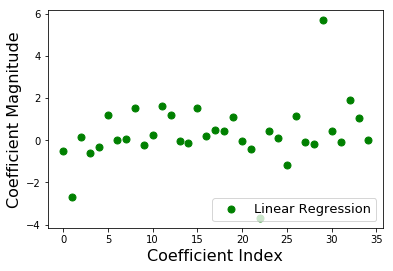

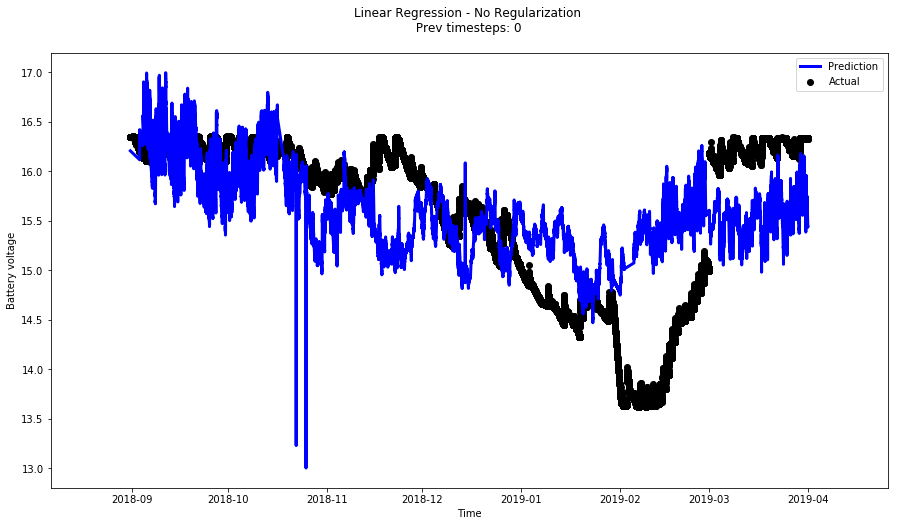

In [60]:
# Choose settings
prev_timesteps_weather = 5
prev_timesteps_bat = 0

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)

# Split data in train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

plot_coefficients(pipeline)

# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat, batt_nr)

The results above show that we cannot only use weather variables to predict the battery voltages. The next thing we'll try is a combination of both previous battery values and weather variables.

### Combination of battery voltages and weather variables

Training score: 0.9998869361677452
Test score: 0.9999373794073805
Coefficients: 
         0         1         2        3         4        5         6   \
0  0.006684  0.005087 -0.008882  0.00273  0.006095 -0.00848  0.000583   

         7         8         9     ...           30        31        32  \
0  0.001218 -0.046819 -0.002171    ...     0.017518 -0.011758 -0.005758   

         33        34        35        36        37        38        39  
0 -0.000396 -0.000766  2.469688  0.275739 -0.029787  0.032691 -0.008519  

[1 rows x 40 columns]


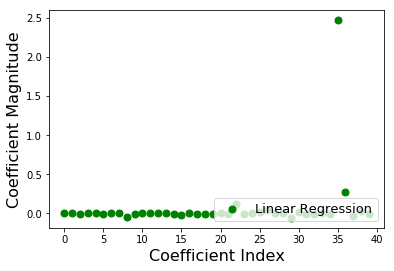

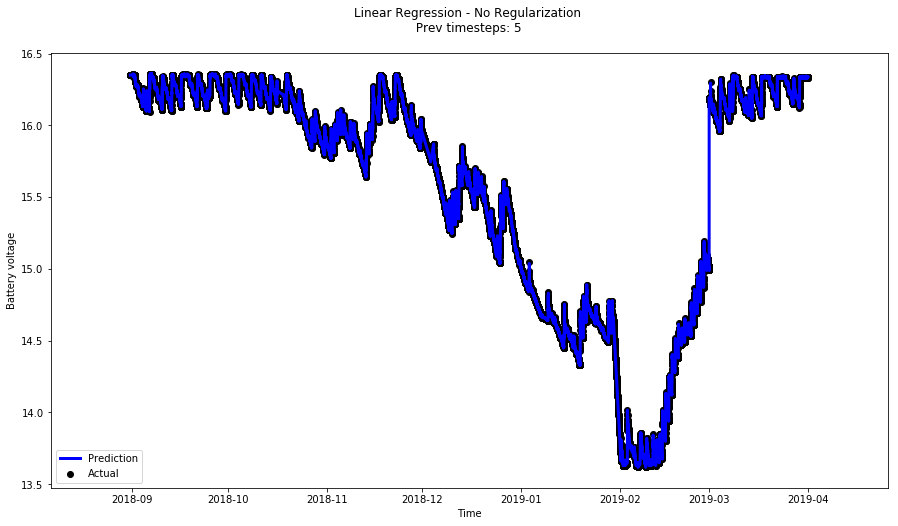

In [66]:
# Choose battery data
batt_nr = 2
battery_voltage = load_battery_voltage(batt_nr)
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 5
prev_timesteps_bat = 5

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)

# Split data in train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

plot_coefficients(pipeline)

# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat, batt_nr)

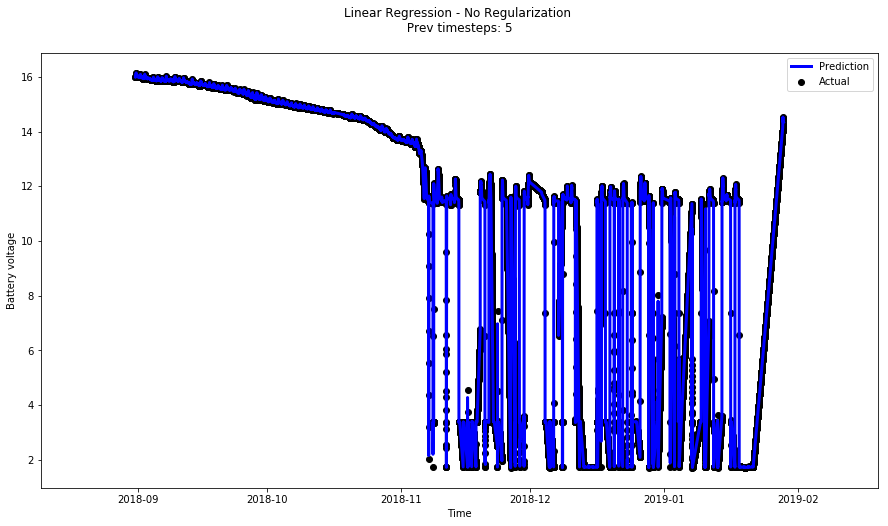

Test score: 0.9964208679114437


In [70]:
# Choose battery data
batt_nr = 1
battery_voltage = load_battery_voltage(batt_nr)
b = battery_voltage.copy()

# Preprocess data
X_test, y_test = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)

# Predict values based on trained set
y_pred = pipeline.predict(X_test)

# Plot the results
plot_pred_actual(X_test, y_test, y_pred, prev_timesteps_bat, batt_nr)
print('Test score: {}'.format(pipeline.score(X_test.iloc[0:len(y_test)], y_test)))

The above results show that it is the battery voltage value of the previous timestamp which has the biggest influence on predicting the battery voltage whereas the coefficients of all the other features are a lot smaller. In the next part we'll try to use a model with regression to deal with this.

# Ridge Regression

## Import libraries

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import numpy as np

## Run ridge regression
We run the algorithm with different values for parameter alpha. For each value of alpha, the coefficients are determined and finally the coefficients are plotted in function of alpha.

In [107]:
batt_nr = 2
battery_voltage = load_battery_voltage(batt_nr)

a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 5
prev_timesteps_bat = 5

# Extend the weather data with more timestamps
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    steps = [
        ('scalar', StandardScaler()),
        ('ridge', Ridge(alpha=a, fit_intercept=False))
    ]
    ridge_pipe = Pipeline(steps)
    ridge_pipe.fit(X_train, y_train)
    coefs.append(ridge_pipe.named_steps['ridge'].coef_[0])


## Plot ridge coefficients in function of alpha

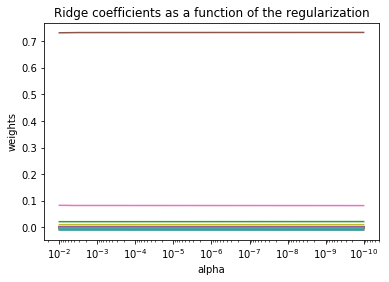

In [109]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Conclusion: Regularization has no effect

# Polynomial Regression

## Import library

In [110]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [112]:
def plot_pred_actual_poly(X_test, y_test, y_pred, prev_timesteps, batt_nr, n_degree, score):
    # Plot prediction vs test set
    fig = plt.figure(figsize=(15,8))
    plt.scatter(y_test.index, y_test, label='Actual',  color='black')
    plt.plot(X_test.index, y_pred, label='Prediction', color='blue', linewidth=3)
    plt.xlabel('Time')
    plt.ylabel('Battery voltage')
    plt.legend()
    plt.title('Polynomial Regression (n = {}) - No Regularization \n Prev timesteps: {} \n Score: {}'.format(n_degree, prev_timesteps, score))
#     plt.savefig(r'C:\Users\JeffG\Desktop\Case 1 - data\Results\Polynomial Regression' + '/ts_{}_batt_{}_n_{}'.format(prev_timesteps, batt_nr, n_degree))
    plt.show()
    return fig

## Polynomial regression without regularization

Training score: 0.9999425621327199
Test score: 0.9863760380085731
Coefficients: 
            0         1         2         3         4        5         6    \
0  2.317234e-13 -0.002293 -0.013357 -0.004969  0.002966 -0.00412 -0.002837   

        7         8        9     ...          143       144       145  \
0  0.000044  0.003264  0.01315   ...     0.000004  0.000022  0.198435   

        146       147       148       149       150      151      152  
0 -0.199894  0.000062  0.053751 -0.053849  0.101263 -0.23461  0.13328  

[1 rows x 153 columns]


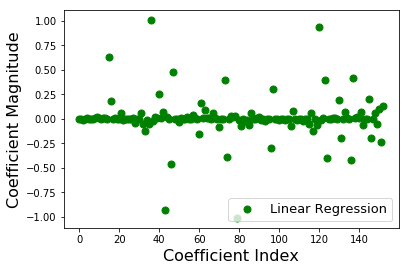

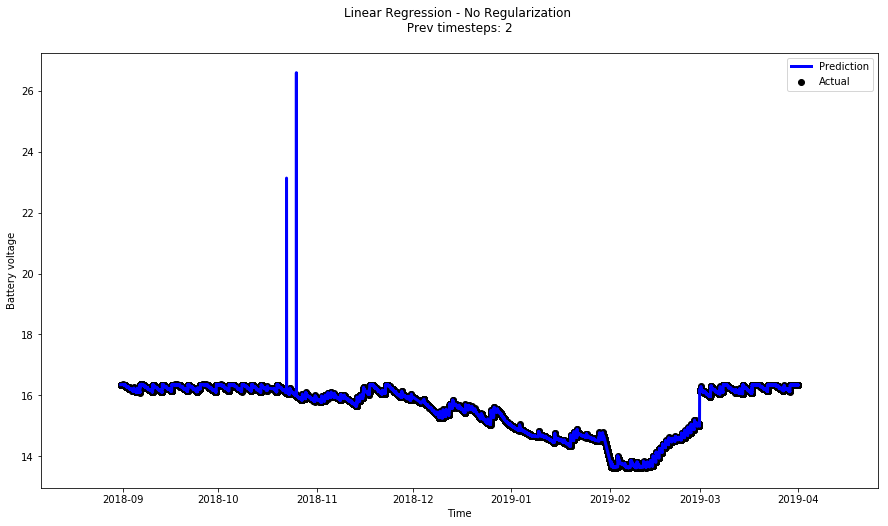

In [118]:
batt_nr = 2
battery_voltage = load_battery_voltage(batt_nr)

a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 2
prev_timesteps_bat = 2
n_degree = 2

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=n_degree)),
    ('model', LinearRegression())
]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

plot_coefficients(pipeline)

# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat, batt_nr)

## Polynomial regression with regularization

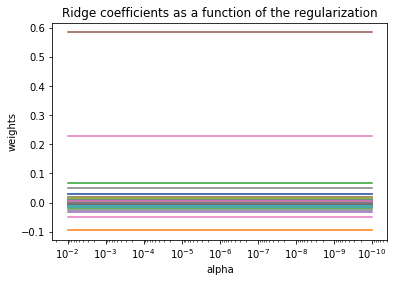

In [120]:
batt_nr = 2
battery_voltage = load_battery_voltage(batt_nr)

a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 2
prev_timesteps_bat = 2
n_degree = 2

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)



n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    # Define pipeline
    steps = [
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(degree=n_degree)),
        ('model', Ridge())
    ]
    ridge_pipe = Pipeline(steps)
    ridge_pipe.fit(X_train, y_train)
    coefs.append(ridge_pipe.named_steps['model'].coef_[0])

# Plot results
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [122]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'scalar', 'poly', 'model', 'scalar__copy', 'scalar__with_mean', 'scalar__with_std', 'poly__degree', 'poly__include_bias', 'poly__interaction_only', 'model__copy_X', 'model__fit_intercept', 'model__n_jobs', 'model__normalize'])

In [123]:
batt_nr = 2
battery_voltage = load_battery_voltage(batt_nr)

a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 2
prev_timesteps_bat = 2

# Extend the weather data with more timestamps
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('ridge', Ridge())
]
ridge_pipe = Pipeline(steps)

param_grid = {'poly__degree': [1, 2, 3],
             'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(ridge_pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# print('Training Score: {}'.format(ridge_pipe.score(X_train, y_train)))
# print('Test Score: {}'.format(ridge_pipe.score(X_test, y_test)))

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'poly__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

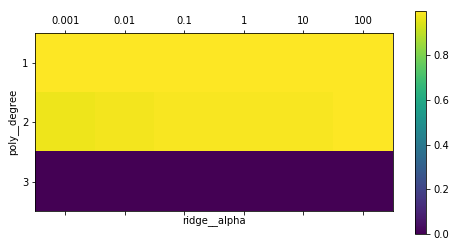

In [126]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3,-1),
           vmin=0,cmap='viridis')
plt.xlabel("ridge__alpha")
plt.ylabel("poly__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])),param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['poly__degree'])), param_grid['poly__degree'])
plt.colorbar()

In [127]:
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters: {'poly__degree': 1, 'ridge__alpha': 0.001}
Test-set score: 1.00


# Experiments

## Define experiment

In [29]:
def linear_regression_experiment(batt_nr, prev_timesteps, training_ratio, train, regr):
    # Get data
    print("Loading data...")
    data = get_data(batt_nr)
    # Extend data with features
    extended_data = add_features(data, prev_timesteps)
    # Scale data and split
    scaled_data, scaler = scale_data(extended_data)
    X_train, y_train, X_test, y_test = split_data(scaled_data, training_ratio)
    print(regr)
    if train == True:
        # Create linear regression object
        regr = linear_model.LinearRegression()
        # Train the model using the training sets
        regr.fit(X_train, y_train)
    # Make predictions using the testing set
    print(regr)
    y_pred = regr.predict(X_test)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print("Mean squared error: %.5f"
          % mse)
    # Explained variance score: 1 is perfect prediction
    r2 = r2_score(y_test, y_pred)
    print('Variance score: %.5f' % r2)
    
    plot_pred_actual(X_test, y_test, y_pred, prev_timesteps, batt_nr, scaler)
    
    return regr, mse, r2

## Run experiments for battery packs

Loading data...
None
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[-0.09811476  0.40954524  0.11079549 -0.21926348 -0.90220009 -0.09542676
  -0.24730647]]
Mean squared error: 0.21225
Variance score: -0.67850


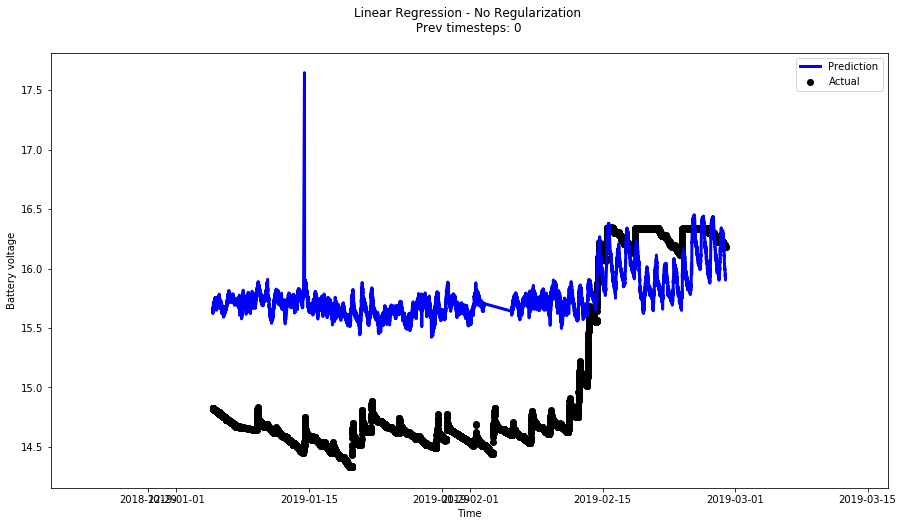

Loading data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[-0.09811476  0.40954524  0.11079549 -0.21926348 -0.90220009 -0.09542676
  -0.24730647]]
Mean squared error: 0.27318
Variance score: -1.22121


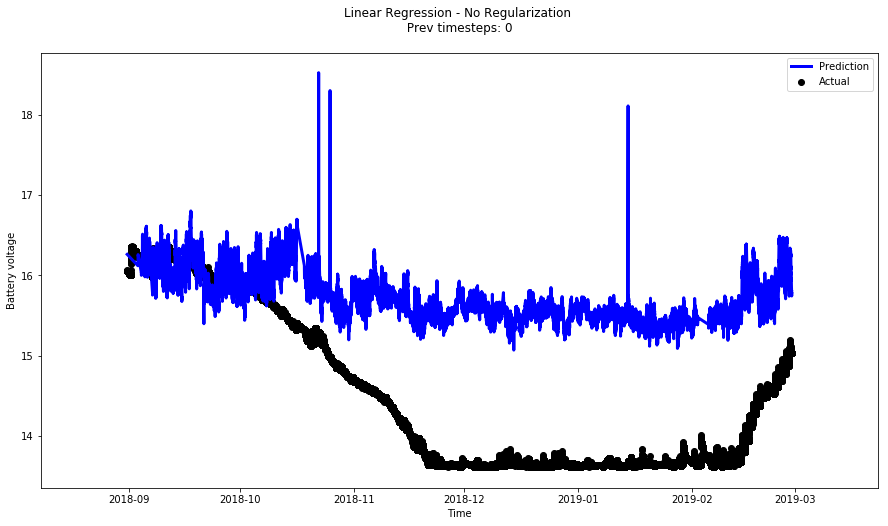

Loading data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[-0.09811476  0.40954524  0.11079549 -0.21926348 -0.90220009 -0.09542676
  -0.24730647]]
Mean squared error: 0.10731
Variance score: 0.10226


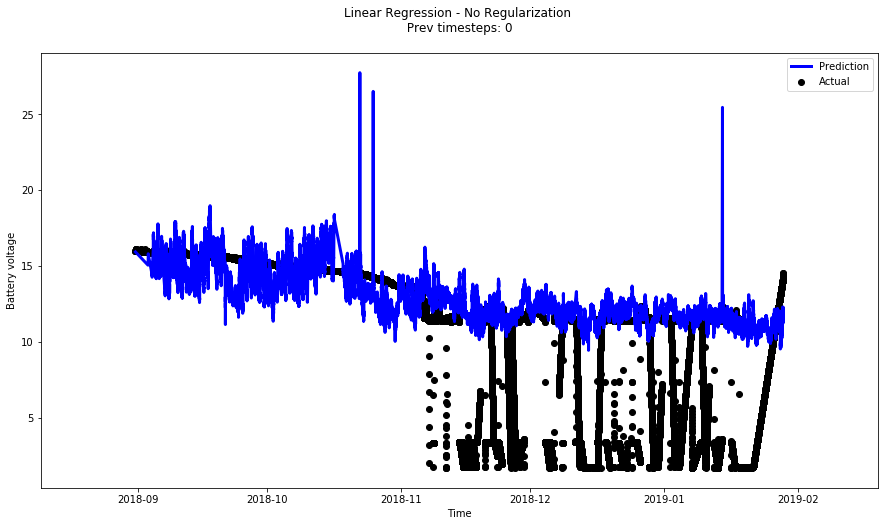

Loading data...
None
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[ 5.20884105e-03 -3.73671592e-04 -2.79916027e-03  5.69261479e-04
  -2.46457240e-04 -5.28057645e-04 -1.30414306e-04  9.99865230e-01]]
Mean squared error: 0.00001
Variance score: 0.99990


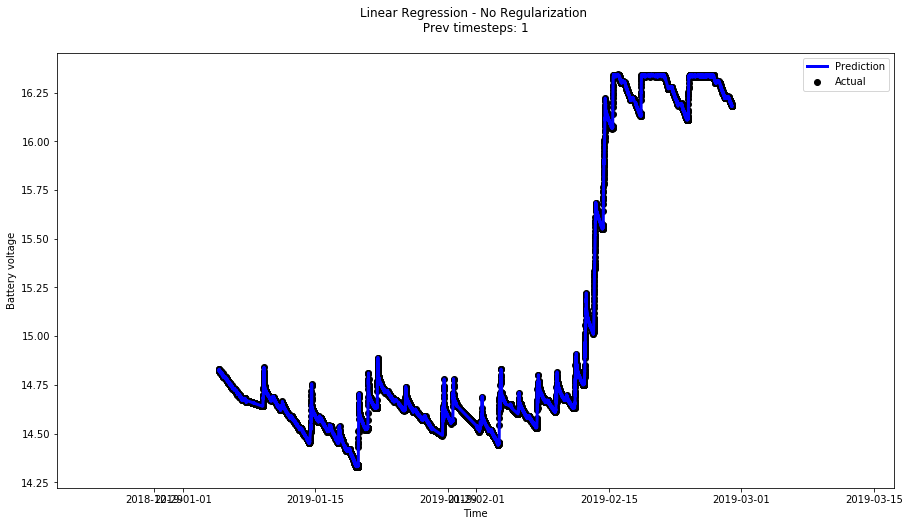

Loading data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[ 5.20884105e-03 -3.73671592e-04 -2.79916027e-03  5.69261479e-04
  -2.46457240e-04 -5.28057645e-04 -1.30414306e-04  9.99865230e-01]]
Mean squared error: 0.00000
Variance score: 0.99997


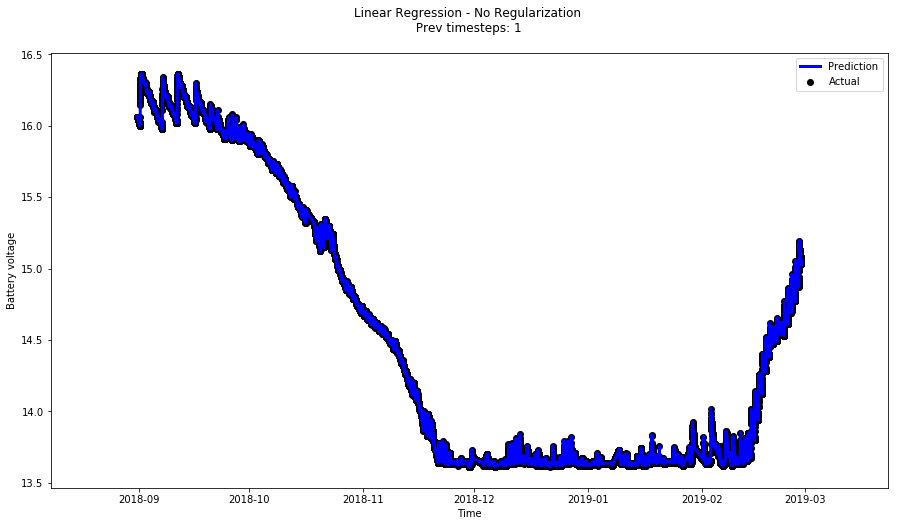

Loading data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[ 5.20884105e-03 -3.73671592e-04 -2.79916027e-03  5.69261479e-04
  -2.46457240e-04 -5.28057645e-04 -1.30414306e-04  9.99865230e-01]]
Mean squared error: 0.00042
Variance score: 0.99649


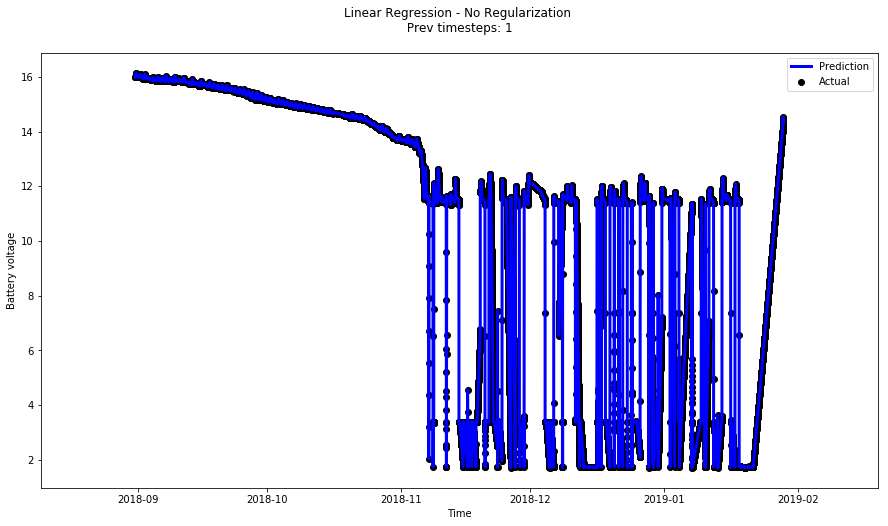

Loading data...
None
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[ 6.09725638e-03 -4.68708326e-04 -3.26789606e-03  6.62068339e-04
  -1.51950725e-04 -5.69123547e-04 -1.17012443e-04  8.17229795e-01
   1.69757069e-01  1.29202079e-02]]
Mean squared error: 0.00001
Variance score: 0.99990


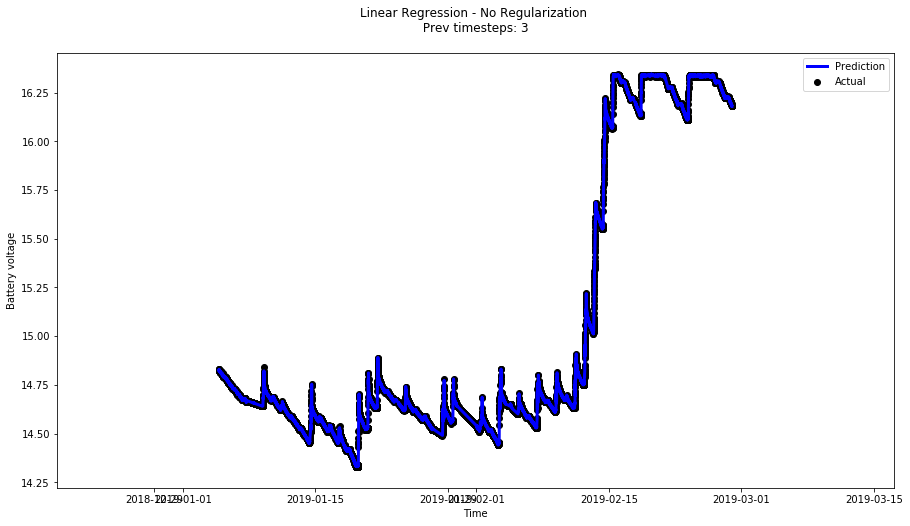

Loading data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[ 6.09725638e-03 -4.68708326e-04 -3.26789606e-03  6.62068339e-04
  -1.51950725e-04 -5.69123547e-04 -1.17012443e-04  8.17229795e-01
   1.69757069e-01  1.29202079e-02]]
Mean squared error: 0.00000
Variance score: 0.99997


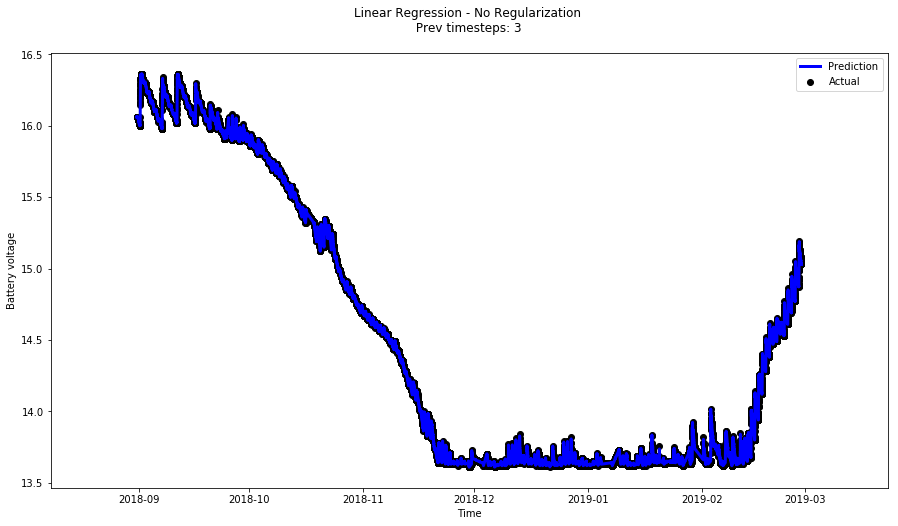

Loading data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficients: 
 [[ 6.09725638e-03 -4.68708326e-04 -3.26789606e-03  6.62068339e-04
  -1.51950725e-04 -5.69123547e-04 -1.17012443e-04  8.17229795e-01
   1.69757069e-01  1.29202079e-02]]
Mean squared error: 0.00044
Variance score: 0.99631


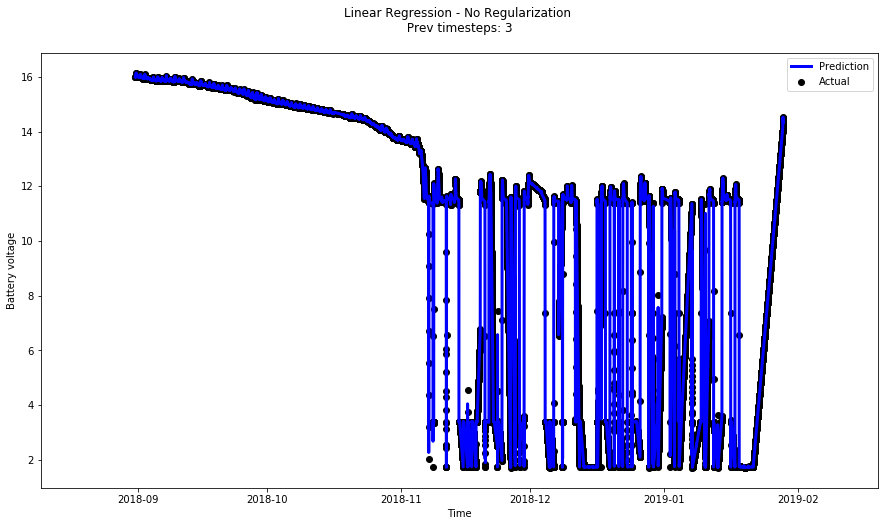

In [31]:
# Run experiment for battery pack nr 2
prev_timesteps = [0, 1, 3]
for ts in prev_timesteps:
    batt_nr = 2
    training_ratio = 0.7
    tr_regr, mse, r2 = linear_regression_experiment(batt_nr, ts, training_ratio, True, None)
    #print(tr_regr)
    batt_nr = 3
    training_ratio = 0
    linear_regression_experiment(batt_nr, ts, training_ratio, False, tr_regr)
    batt_nr = 1
    training_ratio = 0
    linear_regression_experiment(batt_nr, ts, training_ratio, False, tr_regr)